# SVM - Heart Disease Classification
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before using SVC
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### C
Regularization parameter, telling the SVM how it should trade-off maximizing the margin and minimizing classification errors. 

#### Kernel
The kernel type of the algorithm. 

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [1]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

In [2]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `C`: Numbers ranging from 0.001 to 1000
- `kernel`: Kernel types, `linear`, `poly` and `rbf`

In [3]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
    'kernel': ['linear', 'poly', 'rbf']  
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations to further evaluate, we retrieve the ten best combinations from the grid search.

In [4]:
# Define model
model = SVC(random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the ten best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_10 = results.nlargest(10, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_10 = top_10[['param_C', 'param_kernel', 'mean_test_score', 'std_test_score']]

top_10

,param_C,param_kernel,mean_test_score,std_test_score
9,1,linear,0.856781,0.031914
12,10,linear,0.856781,0.031914
15,100,linear,0.856781,0.031914
18,1000,linear,0.856781,0.031914
11,1,rbf,0.856260,0.030868
3,0.01,linear,0.856023,0.036566
6,0.1,linear,0.855320,0.029051
8,0.1,rbf,0.847658,0.040789
10,1,poly,0.844125,0.037912
14,10,rbf,0.841284,0.032276


The top four combinations use linear kernel, and have identical mean score and standard deviation.

### Evaluating top 10 combinations
We will continue by examining how these six top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [5]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [6]:
# DataFrame with evaluation metric for each of the top 10 models
evaluation_results = pd.DataFrame(columns=['C', 'kernel', 'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_10.iterrows():

    # Dict with params from the row
    params = {
        'C': row['param_C'],
        'kernel': row['param_kernel']
    }

    # Fit the model with params
    model = SVC(C=params['C'], kernel=params['kernel'], random_state=42, probability=True)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'C': params['C'],
        'kernel': params['kernel'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score',], ascending=False)
evaluation_results

,C,kernel,Recall,F1-score,Precision,Precision-recall AUC
8,1.00,poly,0.865,0.885,0.906,0.930
0,1.00,linear,0.857,0.891,0.927,0.939
1,10.00,linear,0.857,0.891,0.927,0.939
2,100.00,linear,0.857,0.891,0.927,0.939
3,1000.00,linear,0.857,0.891,0.927,0.939
4,1.00,rbf,0.857,0.887,0.919,0.935
6,0.10,linear,0.857,0.887,0.919,0.939
5,0.01,linear,0.850,0.883,0.919,0.944
9,10.00,rbf,0.842,0.878,0.918,0.932
7,0.10,rbf,0.835,0.874,0.917,0.946


From the results on the unseen data, we will further evaluate a model using `C=1` and `kernel=linear`. This is due to the following considerations:
- The Recall rate is second best, outperforming the one better combination on all other metrics.  
- Has the same `C` as the best combination.
- `linear` is the best-performing kernel type.
- An increase in `C` for a linear kernel appears to have no effect, neither positive nor negative, on the predictions.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for C in the range 0.01 to 100.

In [7]:
def plot_validation_curve(param_name, param_range):
    
    best_params={'kernel': 'linear', 'C': 1}
    # Remove the param name from best params.
    del best_params[param_name]
    
    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        SVC(random_state=42, **best_params),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for SVC, recall")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

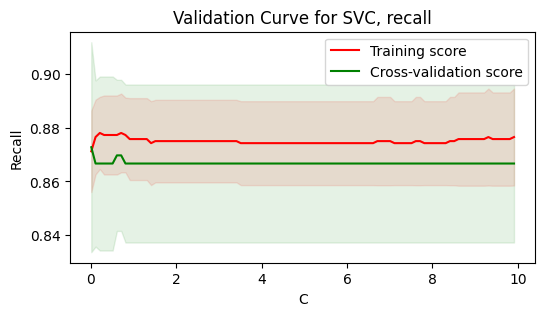

In [8]:
md_range = np.arange(0.01, 10, 0.1)
plot_validation_curve('C', md_range)

We see that the performance is stable starting from a very low C. We therefore plot another Validation Curve, with a lower max C.

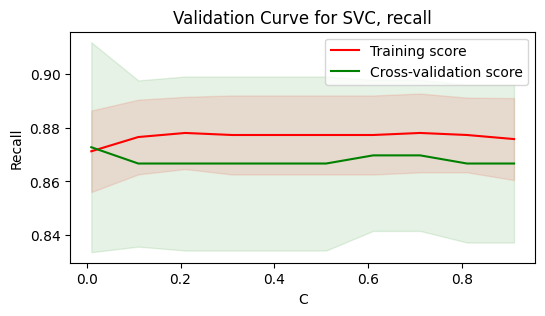

In [9]:
md_range_2 = np.arange(0.01, 1, 0.1)
plot_validation_curve('C', md_range_2)

The model does not appear to be overfitting or underfitting. There also seems to be no gain from increasing the complexity of the model (increasing C), as the training score and CV score curves have flat trends. Our choice of `kernel=linear` and `C=1` seems to be a reasonable choice. 
